# Figure 2: normative imaging associations

## Setup

In [2]:
# Set working directory
%cd work/notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [5]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *


### Compute components

In [13]:
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


### Compute null models for spin tests

Generate null models and save to file, using functions from `code/maps_null_test.py`

In [ ]:
spins = generate_spins(n=5000, blocks=1, density='41k', save_name = 'spins_41k_5000_v2')

                            00
Saved spins to ../outputs/permutations/spins_41k_5000_v2.npy

Generated 1 blocks of 5000 spins at density 41k


Read HCP parcellation files and  to fsaverage at given 41k density using code from `neuromaps` package

In [ ]:
hcp_img_files = ('../data/parcellations/lh.HCPMMP1.annot',
                 '../data/parcellations/rh.HCPMMP1.annot')
hcp_img = annot_to_gifti(hcp_img_files)

hcp_img_41k = fsaverage_to_fsaverage(hcp_img, target_density='41k', method='nearest')

Project components to spins and reaverage

In [ ]:
# spins = np.load("../outputs/permutations/spins_41k_5000.npy")
generate_nulls_from_components(scores, spins, parcellation_img = hcp_img_41k, density='41k',
                               n=5000, save_name = 'dme_3d_ds5_clean_spin_41k_5000')


Generated 5000 null spins of component 0

Generated 5000 null spins of component 1

Generated 5000 null spins of component 2
Saved null spins to ../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000_v2.npy


In [ ]:
scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000.npy")

---

## Get imaging maps

In [346]:
maps_with_scores = (get_maps()
                   .join(dme_3d_ds5.clean_scores().set_index('label'))
                   .apply(lambda x: (x-np.mean(x))/np.std(x))
)

In [347]:
map_corrs_all = corr_nulls_from_grads(null_scores, scores, maps_with_scores.drop(['C1','C2','C3'], axis=1), adjust_by_label=True)
# map_corrs_all

## Correlation matrix with annotations

In [348]:
corrmat = make_correlation_matrix(maps_with_scores
                                  .drop(['paquola_FC','MEG_theta', 'dMT'], axis=1),
            gamma=.8, seed=1, method='pearson', cluster_reorder_dict={3:2,2:3})

n clusters 3


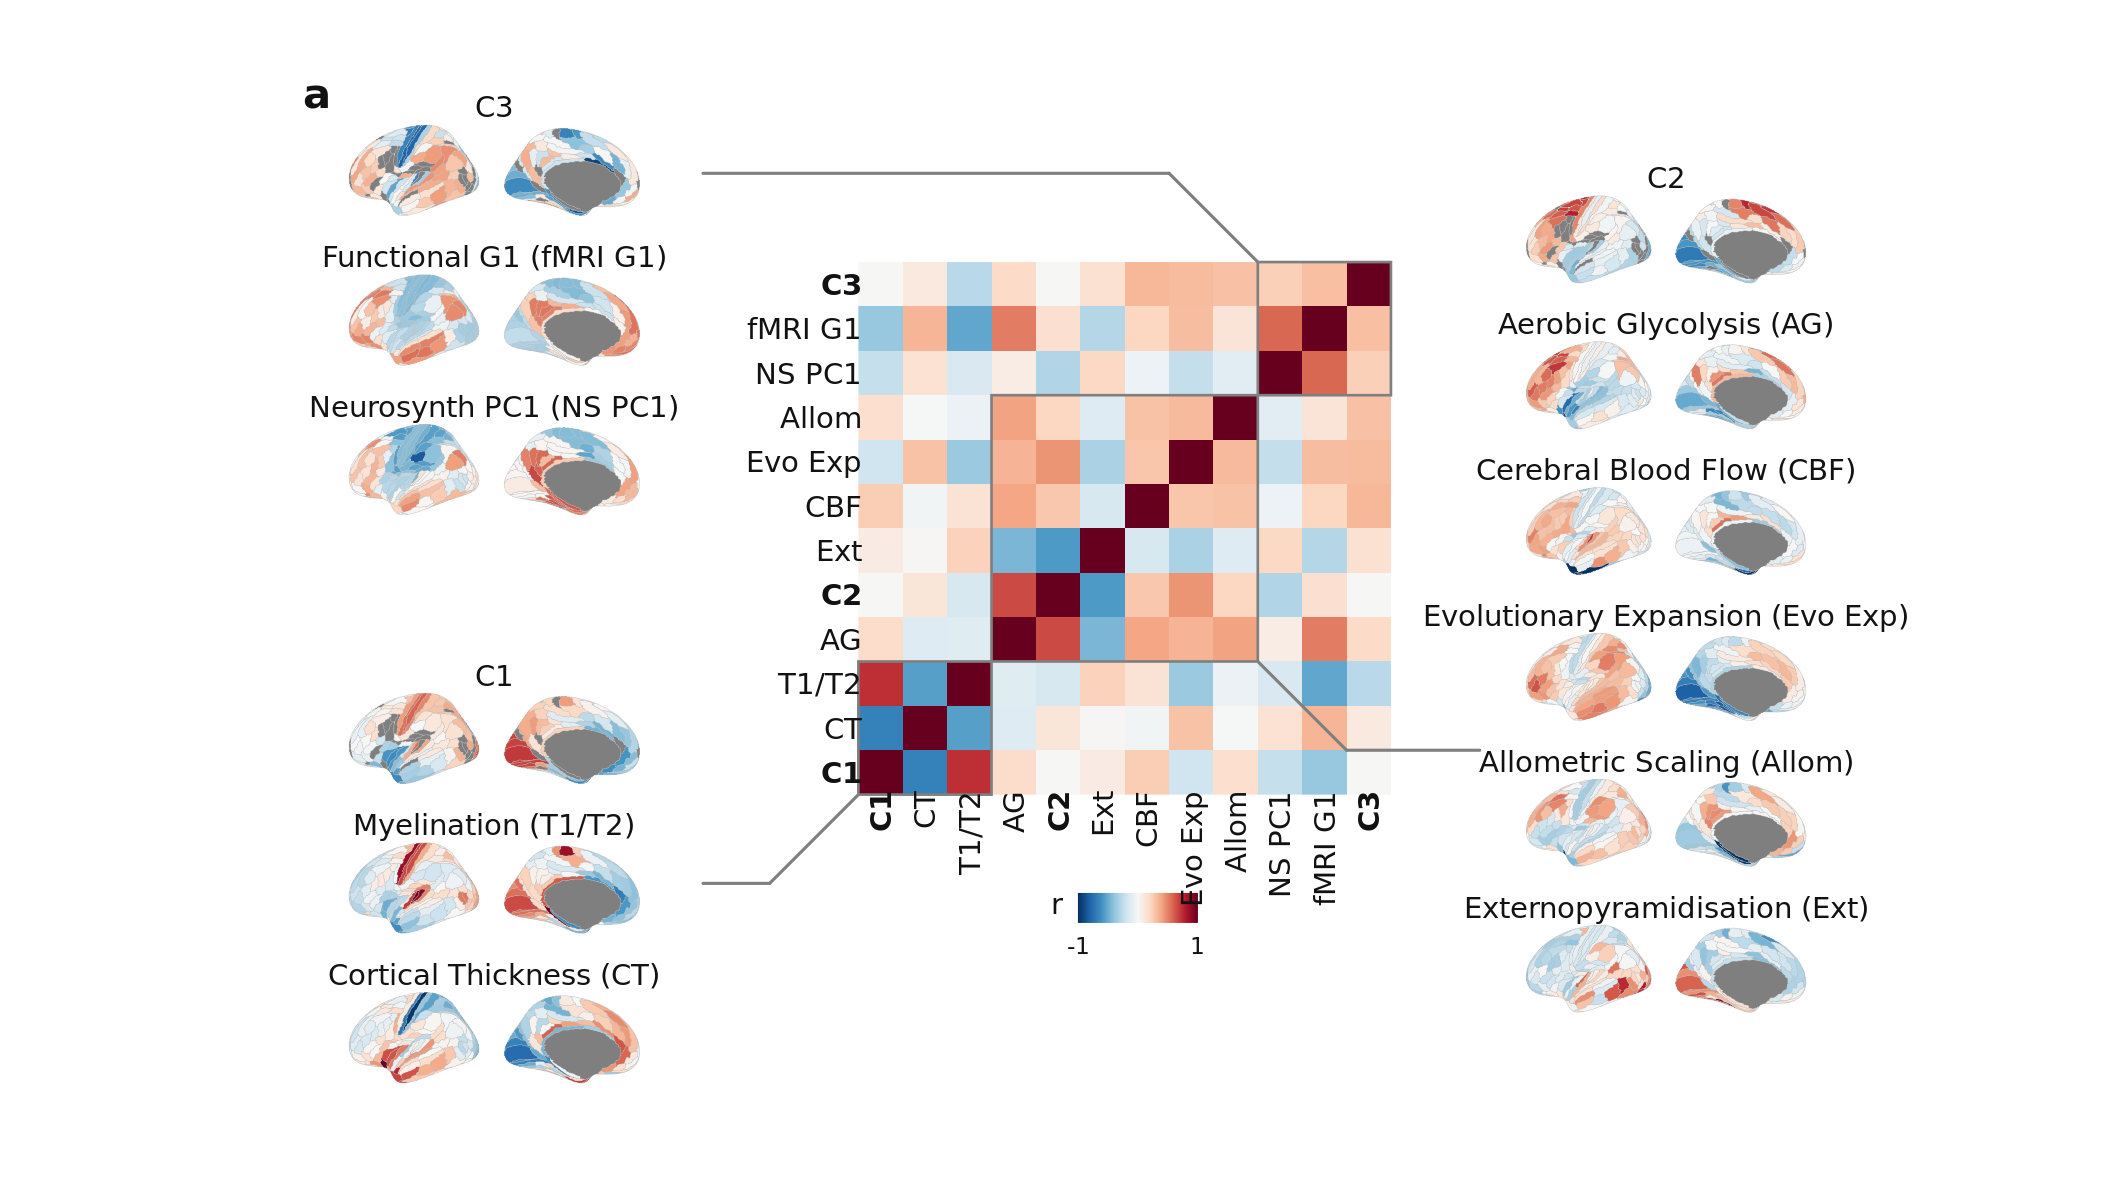

In [500]:
%%R -i maps_with_scores -i corrmat -w 180 -h 100 -u mm -r 300
source("../code/fig2_plots.R")

rename_list <- list(
    `C3` = 'C3',
    `Functional G1 (fMRI G1)` = 'G1_fMRI',
    `Neurosynth PC1 (NS PC1)` = 'PC1_neurosynth',

    `C1` = 'C1',
    `Myelination (T1/T2)` = 'T1T2',
    `Cortical Thickness (CT)` = 'thickness',
    
    `C2` = 'C2',
    `Aerobic Glycolysis (AG)` = 'glasser_GI',
    `Cerebral Blood Flow (CBF)` = 'CBF',
    `Evolutionary Expansion (Evo Exp)` = 'hill_evo',
    `Allometric Scaling (Allom)` = 'allom',
    `Externopyramidisation (Ext)` = 'externopyramidisation'
) %>% unlist

g_corrmat <- plot_corrmat(corrmat) +
    theme(
        plot.margin = margin(t=18, b=18, l=0, r=0, unit='mm'),
        legend.position = c(.5,-.25),
        legend.direction = 'horizontal'
    )

# g_corrmat

maps_C3 <- maps_with_scores %>% select_(.dots = rename_list[c(1:3)]) %>% 
            plot_brain_maps() + theme(legend.position='none')
maps_C1 <- maps_with_scores %>% select_(.dots = rename_list[c(4:6)]) %>% 
            plot_brain_maps() + theme(legend.position='none')
maps_C2 <- maps_with_scores %>% select_(.dots = rename_list[c(7:12)]) %>% 
            plot_brain_maps() + theme(legend.position='none')


library(grid)
line_lr <- linesGrob(gp = gpar(col = "grey50", lwd = 1))
line_rl <- linesGrob(gp = gpar(col = "grey50", lwd = 1), y = c(1,0))

g_corrmat_and_lines <- 
    g_corrmat + labs(tag = 'a') +
    # C3 lines
    annotation_custom(grob=line_rl, xmin=9.5, xmax=7.5, ymin=12.5, ymax=14.5) +
    annotation_custom(grob=line_rl, xmin=7.5, xmax=-3, ymin=14.5, ymax=14.5) +
    # annotation_custom(grob=line_rl, xmin=-3.5, xmax=-3.5, ymin=6.5, ymax=15.5) +
    # C1 lines
    annotation_custom(grob=line_lr, xmin=0.5, xmax=-1.5, ymin=0.5, ymax=-1.5) +
    annotation_custom(grob=line_lr, xmin=-1.5, xmax=-3, ymin=-1.5, ymax=-1.5) +
    # annotation_custom(grob=line_rl, xmin=-3.5, xmax=-3.5, ymin=-4.5, ymax=4) +
    # C2 lines
    # annotation_custom(grob=line_rl, xmin=9.5, xmax=14.5, ymin=6.5, ymax=6.5)
    annotation_custom(grob=line_rl, xmin=9.5, xmax=11.5, ymin=3.5, ymax=1.5) +
    annotation_custom(grob=line_rl, xmin=11.5, xmax=14.5, ymin=1.5, ymax=1.5) 

g_corrmat_and_maps <- (
    (g_corrmat_and_lines & theme(plot.tag.position = c(-.57,1.2))) +
    # Brain maps
    inset_element(maps_C3, left=-.6, right=0, bottom=.6, top=1.2, align_to = 'plot', ignore_tag=TRUE) + 
    inset_element(maps_C1, left=-.6, right=0, bottom=-.2, top=.4, align_to = 'plot', ignore_tag=TRUE) +
    inset_element(maps_C2, left=1.1, right=1.6, bottom=-.1, top=1.1, align_to = 'plot', ignore_tag=TRUE)
)

g_corrmat_and_maps # + plot_annotation(tag_level='a')

## Mesulam

In [360]:
hcp_info = fetch_hcp()['info']

In [361]:
hcp_yeo_mesulam = get_yeo_mesulam(scores=dme_3d_ds5.clean_scores())
mesulam_null_p = compute_null_p(*compute_region_means(dme_3d_ds5.scores, null_scores, hcp_yeo_mesulam['Mesulam_names'], method='median')).sort_values(['C','label'])

In [362]:
labels = hcp_yeo_mesulam['Mesulam']
true, null = compute_region_fscores(labels, dme_3d_ds5.scores, null_scores, name='Mesulam')
compute_null_p(true, null)

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig
0,Mesulam,C1,1.000,61.455792,8.080201,6.332922,8.428272,True,0.000,0.000,True
1,Mesulam,C2,0.293,4.716009,9.399433,7.258355,-0.645246,False,0.586,0.586,False
2,Mesulam,C3,1.000,49.045725,5.047218,4.023480,10.935436,True,0.000,0.000,True


Adding missing grouping variables: `classes`, `colors`


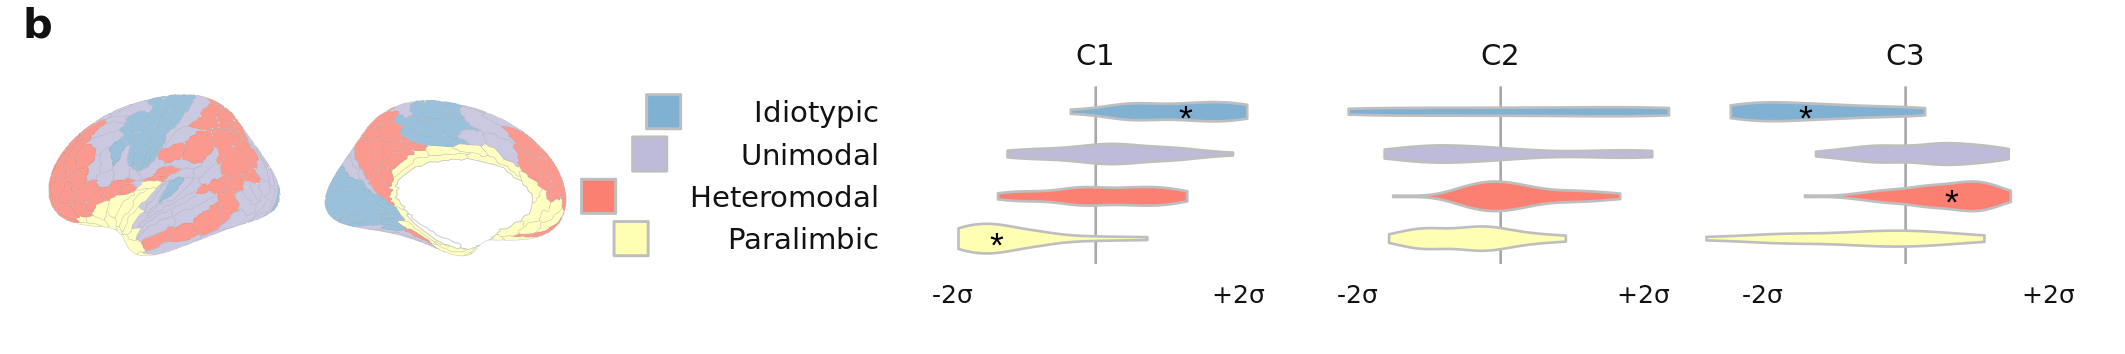

In [363]:
%%R -i hcp_yeo_mesulam -i mesulam_null_p -w 180 -h 30 -u mm -r 300
source("../code/fig2_plots.R")
mesulam_brains <- plot_brain_classes(hcp_yeo_mesulam, Mesulam_colors, Mesulam_names) + labs(tag='b')
mesulam_violins <- plot_class_violins(hcp_yeo_mesulam, mesulam_null_p)
g_mesulam <- mesulam_brains + mesulam_violins
g_mesulam

## Specific maps

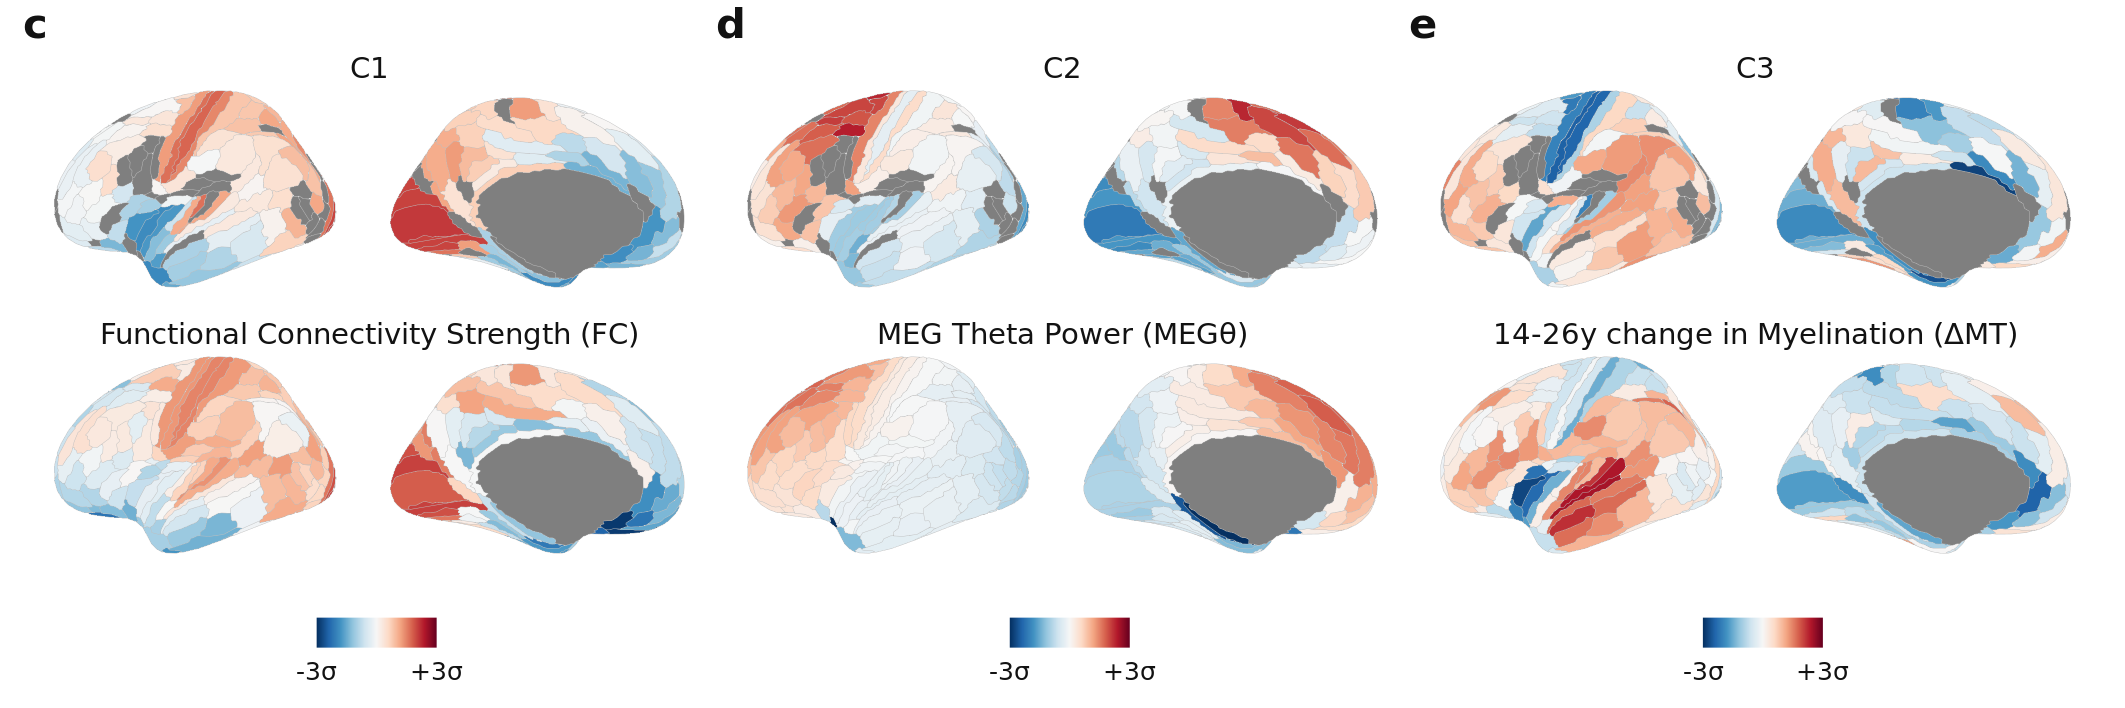

In [365]:
%%R -i maps_with_scores -w 180 -h 60 -u mm -r 300
source("../code/fig2_plots.R")

rename_list <- list(
    `C1` = 'C1', 
    `C2` = 'C2', 
    `C3` = 'C3',
    `Functional Connectivity Strength (FC)` = 'paquola_FC',
    `MEG Theta Power (MEGθ)` = 'MEG_theta',
    `14-26y change in Myelination (ΔMT)` = 'dMT'
) %>% unlist

g1 <- maps_with_scores %>% select_(.dots = rename_list[c(1,4)]) %>% plot_brain_maps + labs(tag='c')
g2 <- maps_with_scores %>% select_(.dots = rename_list[c(2,5)]) %>% plot_brain_maps + labs(tag='d')
g3 <- maps_with_scores %>% select_(.dots = rename_list[c(3,6)]) %>% plot_brain_maps + labs(tag='e')

g_specific_brains <- (g1 + g2 + g3)
g_specific_brains


## Scatter plots for specific maps

In [353]:
scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000.npy")

maps_to_test = ['paquola_FC','MEG_theta','dMT']
map_corrs = corr_nulls_from_grads(null_scores, scores, maps_with_scores.loc[:,maps_to_test])#, adjust_by_label=True)
map_corrs.sort_values(['map', 'C'])

,C,map,r,p,q
1,C1,MEG_theta,-0.179346,0.740252,0.984803
4,C2,MEG_theta,0.781395,0.008598,0.026395
7,C3,MEG_theta,-0.015159,0.961008,0.984803
2,C1,dMT,0.166190,0.604879,0.984803
5,C2,dMT,0.152522,0.672665,0.984803
8,C3,dMT,0.430203,0.008798,0.026395
0,C1,paquola_FC,0.778982,0.000600,0.005399
3,C2,paquola_FC,-0.013908,0.982204,0.984803
6,C3,paquola_FC,-0.004576,0.984803,0.984803


In [351]:
maps_for_scatter = (maps_with_scores.join(get_yeo_mesulam().set_index('region')))
maps_for_scatter

,paquola_FC,T1T2,MEG_theta,glasser_GI,dMT,hill_evo,externopyramidisation,thickness,PC1_neurosynth,G1_fMRI,...,Lobe,Lobe_colors,Lobe_names,Yeo,Yeo_names,Yeo_colors,Yeo_shortnames,Mesulam,Mesulam_colors,Mesulam_names
label,,,,,,,,,,,,,,,,,,,,,
V1,1.820896,1.977036,-0.914991,-1.523300,-1.694981,-2.446501,1.769126,-2.310289,0.261369,-0.750526,...,Occ,#E41A1C,Occipital,1.0,Visual,#660066,VIS,4,#80B1D3,Idiotypic
MST,0.863636,1.575121,-0.609940,-0.392062,-0.450940,0.067569,0.630473,-0.815568,-0.536989,-1.042511,...,Occ,#E41A1C,Occipital,1.0,Visual,#660066,VIS,3,#BEBADA,Unimodal
V6,1.315350,1.647248,-1.100668,-0.755553,0.087768,-1.870358,-1.006875,-1.721457,0.056781,-1.135492,...,Occ,#E41A1C,Occipital,1.0,Visual,#660066,VIS,3,#BEBADA,Unimodal
V2,2.056486,1.665496,-0.949788,-1.113092,-1.109890,-2.070317,1.377546,-2.030079,0.056781,-0.933047,...,Occ,#E41A1C,Occipital,1.0,Visual,#660066,VIS,4,#80B1D3,Idiotypic
V3,1.928231,1.430449,-1.103299,-0.421922,-0.600836,-1.813154,1.888340,-1.497054,0.056781,-0.953694,...,Occ,#E41A1C,Occipital,1.0,Visual,#660066,VIS,4,#80B1D3,Idiotypic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STSva,-0.543768,-0.795757,-0.223971,-0.482769,2.206353,1.189967,1.400205,0.205376,1.234535,1.434124,...,Temp,#7E6E85,Temporal,7.0,Default,#FF6666,DMN,3,#BEBADA,Unimodal
TE1m,-1.377902,-0.634758,-0.239697,0.461361,1.392075,1.581797,-0.677230,1.084687,0.056781,1.611986,...,Temp,#7E6E85,Temporal,7.0,Default,#FF6666,DMN,2,#FB8072,Heteromodal
PI,-0.747427,-1.391843,-0.169800,-1.762716,0.175215,-0.268852,-1.012710,-0.240927,0.056781,-0.607650,...,Temp,#7E6E85,Temporal,5.0,Limbic,#FFFF99,LIM,1,#FFFFB3,Paralimbic


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


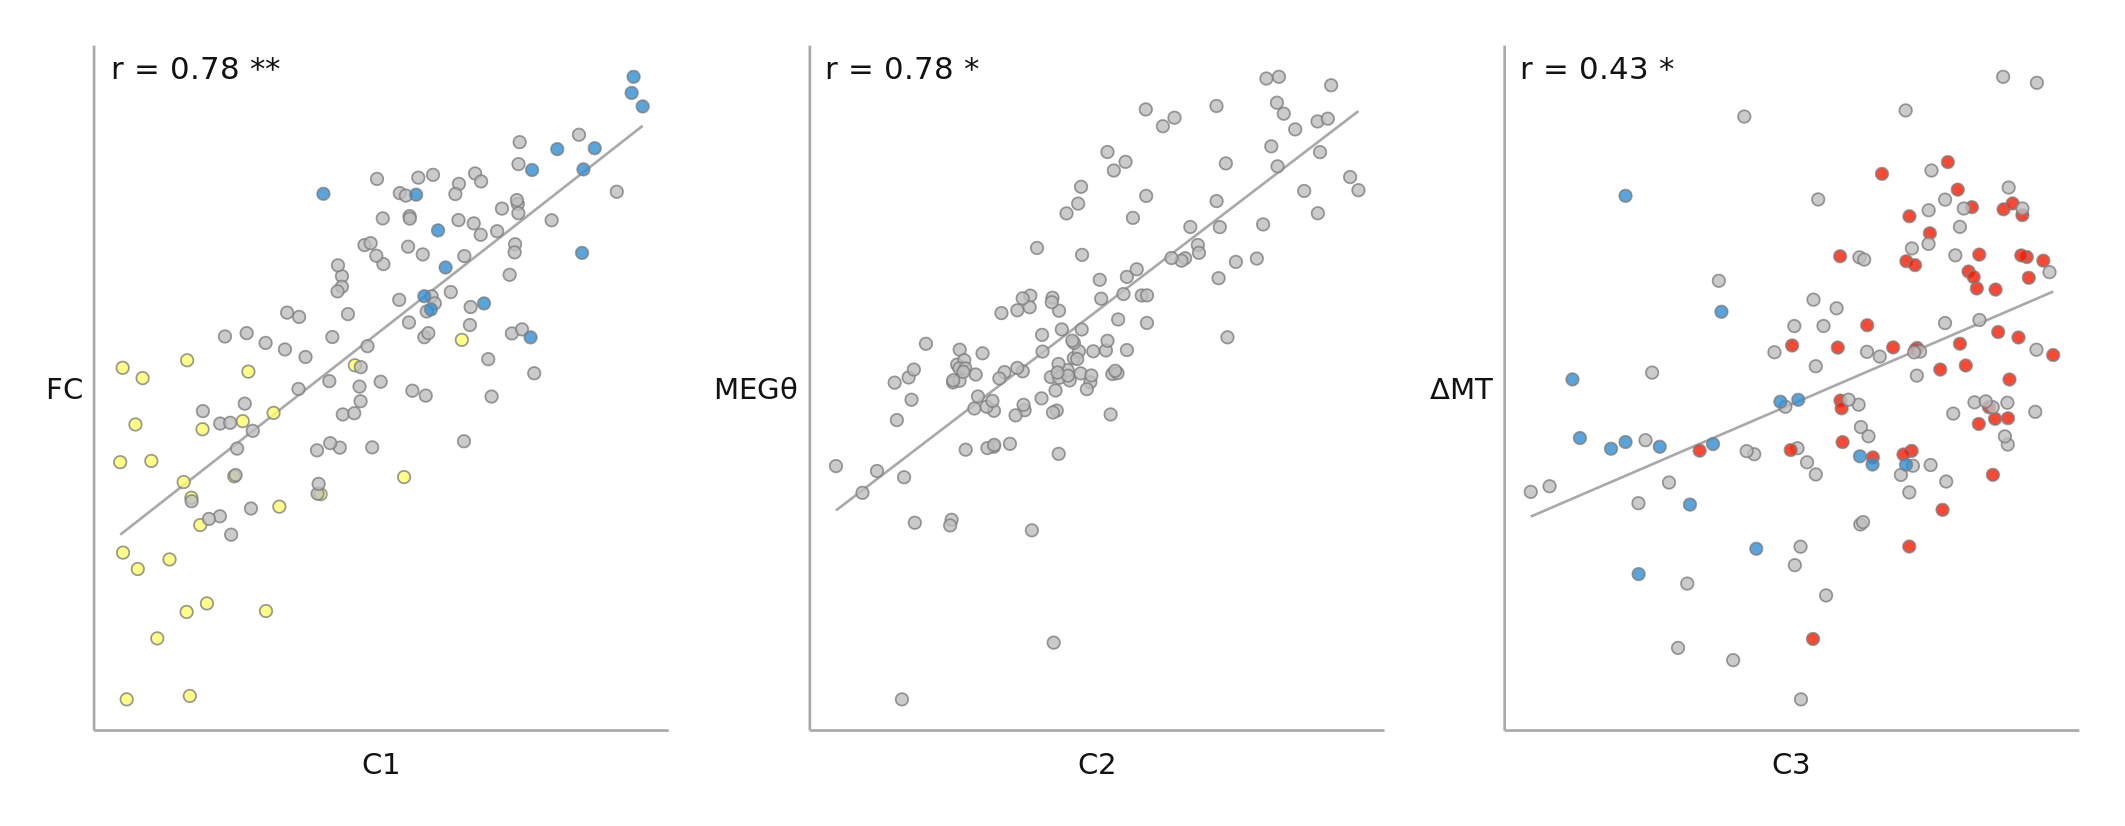

In [354]:
%%R -i maps_for_scatter -i map_corrs -w 180 -h 70 -u mm -r 300
source("../code/fig2_plots.R")
maps_for_scatter$Mesulam_names %>% unique
g1 <- maps_for_scatter %>% plot_scatter_with_colors(corrs=map_corrs, x_var='C1', y_var='paquola_FC', y_name='FC', color_var='Mesulam', color_selection=c('Idiotypic','Paralimbic'))
g2 <- maps_for_scatter %>% plot_scatter_with_colors(corrs=map_corrs, x_var='C2', y_var='MEG_theta', y_name='MEGθ', color_var='Mesulam', color_selection=c(''))
g3 <- maps_for_scatter %>% plot_scatter_with_colors(corrs=map_corrs, x_var='C3', y_var='dMT', y_name='ΔMT', color_var='Mesulam', color_selection=c('Idiotypic','Heteromodal')) 

g_scatters <- g1 | g2 | g3
g_scatters

## Combined Fig 2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


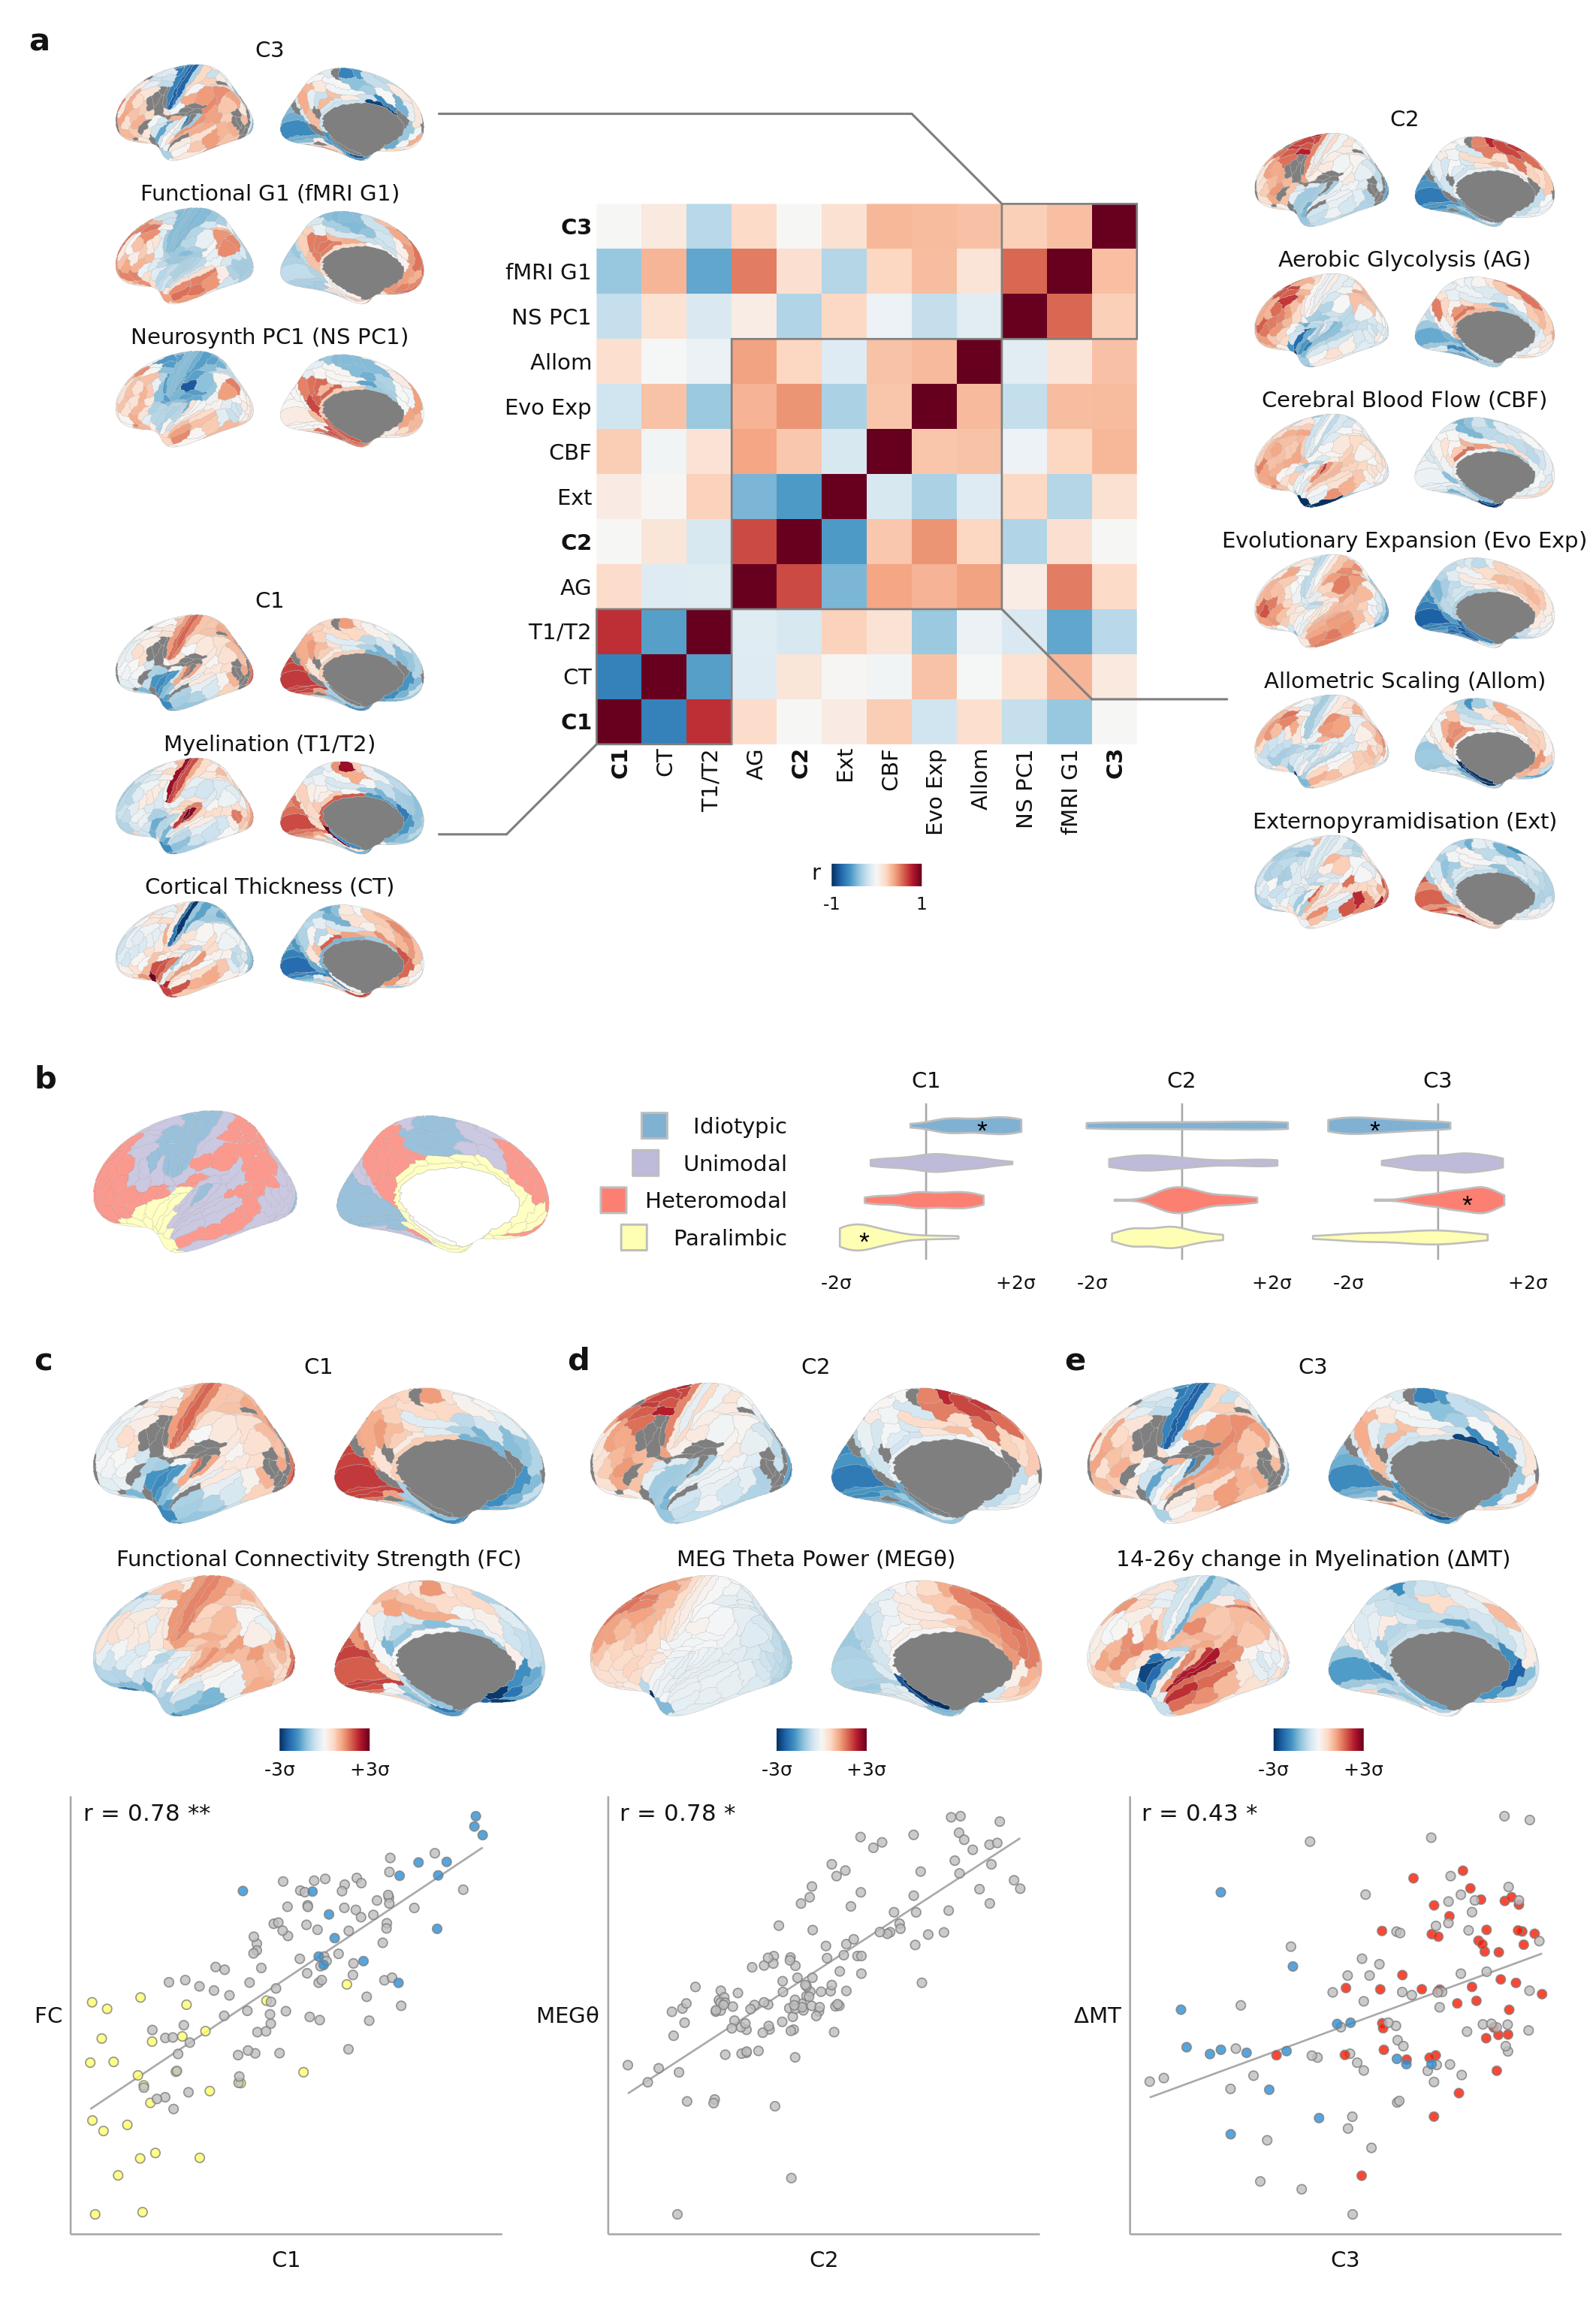

In [501]:
%%R -w 180 -h 260 -u mm -r 300

g_corrmat_and_maps <- g_corrmat_and_maps & theme(plot.tag.position = c(-.65,1.2))
g_mesulam <- g_mesulam & theme(plot.tag.position=c(0,.91))
g_specific_brains <- g_specific_brains & theme(
                                            legend.margin = margin(t=-3, b=0, l=0, r=0, unit='mm'),
                                            plot.tag.position = c(0,.96)
                                        )

design <- c(
  area(t = 1, b = 95, l = 2, r = 180),
  area(t = 101, b = 125, l = 1, r = 180),
  area(t = 131, b = 190, l = 1, r = 180),
  area(t = 191, b = 260, l = 1, r = 180)
)

plot <- g_corrmat_and_maps / g_mesulam / g_specific_brains / g_scatters + plot_layout(design=design)
plot

## Other Fig 2 analyses

In [ ]:
(corrmat
 .loc[lambda x: ~x['x'].str.contains('C')]
 .loc[lambda x: ~x['y'].str.contains('C')]
 .loc[lambda x: x['x']!=x['y'],'r']
 .abs()
 .quantile(.2)
)

0.13203399668602048

In [737]:
(maps_with_scores.corr().iloc[:,12:].round(2)
 .assign(which = lambda x: x.abs().idxmax(axis=1))
 )

,C1,C2,C3,which
paquola_FC,0.78,-0.01,-0.00,C1
T1T2,0.74,-0.16,-0.28,C1
MEG_theta,-0.18,0.78,-0.02,C2
glasser_GI,0.18,0.66,0.19,C2
dMT,0.17,0.15,0.43,C3
hill_evo,-0.20,0.45,0.32,C2
externopyramidisation,0.08,-0.57,0.15,C2
thickness,-0.68,0.12,0.10,C1
PC1_neurosynth,-0.23,-0.30,0.24,C2
G1_fMRI,-0.38,0.16,0.30,C1


In [ ]:
scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000.npy")

map_corrs_all = corr_nulls_from_grads(null_scores, scores, maps_with_scores.drop(['C1','C2','C3'],axis=1))#, adjust_by_label=True)
map_corrs_all.sort_values(['map', 'C'])

,C,map,r,p,q
11,C1,CBF,0.249742,0.224755,0.475952
23,C2,CBF,0.274225,0.174765,0.408968
35,C3,CBF,0.330148,0.080984,0.310646
9,C1,G1_fMRI,-0.380419,0.061388,0.310646
21,C2,G1_fMRI,0.156958,0.558688,0.800583
33,C3,G1_fMRI,0.301190,0.099580,0.310646
2,C1,MEG_theta,-0.179413,0.740252,0.840432
14,C2,MEG_theta,0.781389,0.008598,0.052789
26,C3,MEG_theta,-0.015219,0.960808,0.984803
8,C1,PC1_neurosynth,-0.233789,0.472505,0.773191
